In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request
from matplotlib.font_manager import fontManager
import matplotlib
import pandas as pd
import properscoring as ps
from scipy.stats import t
import gc

In [2]:
def plot_timeseries_with_uncertainty(
    ground_truth,
    median_prediction,
    prediction_samples,
    baseline_prediction,
    node_idx,
    save_path="prediction_visualization.png"
):
    """
    绘制单个站点的时序预测与不确定性区间，并与基线模型对比。

    参数:
    - ground_truth (np.array): 形状为 (pred_len,) 的未来真实值。
    - median_prediction (np.array): 形状为 (pred_len,) 的中位数预测值。
    - prediction_samples (np.array): 形状为 (num_samples, pred_len) 的多次采样预测结果。
    - baseline_prediction (np.array): 形状为 (pred_len,) 的基线模型预测值。
    - node_idx (int): 要可视化的充电桩（节点）的索引。
    - save_path (str): 图片保存路径。
    """
    plt.rcParams['font.sans-serif'] = ['微软雅黑', 'SimHei', 'Heiti TC', 'PingFang SC', 'sans-serif']  # 指定一个支持中文的字体，例如“黑体”
    plt.rcParams['axes.unicode_minus'] = False   # 解决负号'-'显示为方块的问题
    
    pred_len = len(ground_truth)

    # --- 计算不确定性区间 ---
    # 沿样本维度（axis=0）计算第5和第95百分位数
    lower_bound = np.percentile(prediction_samples, 5, axis=0)
    upper_bound = np.percentile(prediction_samples, 95, axis=0)

    # --- 开始绘图 ---
    # 设置更美观的绘图风格
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))

    # 创建时间轴
    future_time = np.arange(pred_len)

    # 1. 绘制未来真实值
    ax.plot(future_time, ground_truth, 'r-', linewidth=2, label='Ground Truth')

    # 2. 绘制我们模型的中位数预测
    ax.plot(future_time, median_prediction, 'b-', linewidth=2, label='Our Model Median')
    
    # 3. 绘制基线模型的预测
    ax.plot(future_time, baseline_prediction, 'g--', linewidth=2, label='Baseline: TimeXer')

    # 4. 绘制我们模型的不确定性区间（阴影区域）
    ax.fill_between(
        future_time, lower_bound, upper_bound, color='blue', alpha=0.2,
        label='Our Model 90% C.I.'
    )

    # --- 设置图表标题和标签 ---
    ax.set_title(f'Charging Pile {node_idx} Prediction Comparison', fontsize=18)
    ax.set_xlabel('Prediction Time Step', fontsize=12)
    ax.set_ylabel('Occupancy', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True)
    
    # 调整布局并保存图片
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path)
    print(f"可视化图表已保存至: {save_path}")

In [16]:
def calculate_metrics(y_true, y_pred_median, y_pred_samples):

    y_pred_samples= y_pred_samples.astype(np.float16)
    metrics = {}
    metrics['mae'] = float(np.mean(np.abs(y_pred_median - y_true)))
    metrics['rmse'] = float(np.sqrt(np.mean((y_pred_median - y_true)**2)))
    rae_numerator = np.sum(np.abs(y_pred_median - y_true))
    rae_denominator = np.sum(np.abs(np.mean(y_true) - y_true))
    metrics['rae'] = float(rae_numerator / (rae_denominator + 1e-9))
    non_zero_mask = y_true != 0
    metrics['mape'] = float(np.mean(np.abs((y_pred_median[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask])) * 100) if np.any(non_zero_mask) else 0.0
    gc.collect()
    metrics['crps'] = float(ps.crps_ensemble(y_true, y_pred_samples.transpose(1, 0, 2, 3), axis=0).mean())

    horizon_metrics = []
    for i in range(y_true.shape[1]): # 遍历预测长度
        y_true_h, y_pred_median_h, y_pred_samples_h = y_true[:, i, :], y_pred_median[:, i, :], y_pred_samples[:, :, i, :]
        mae_h = float(np.mean(np.abs(y_pred_median_h - y_true_h)))
        rmse_h = float(np.sqrt(np.mean((y_pred_median_h - y_true_h)**2)))
        rae_num_h = np.sum(np.abs(y_pred_median_h - y_true_h))
        rae_den_h = np.sum(np.abs(np.mean(y_true_h) - y_true_h))
        rae_h = float(rae_num_h / (rae_den_h + 1e-9))
        non_zero_mask_h = y_true_h != 0
        if np.any(non_zero_mask_h):
            mape_h = float(np.mean(np.abs((y_pred_median_h[non_zero_mask_h] - y_true_h[non_zero_mask_h]) / y_true_h[non_zero_mask_h])) * 100)
        else:
            mape_h = 0.0
        crps_h = float(ps.crps_ensemble(y_true_h, y_pred_samples_h.transpose(1, 0, 2), axis=0).mean())
        horizon_metrics.append([f't+{i+1}', mae_h, rmse_h, rae_h, mape_h, crps_h])

    df = pd.DataFrame(horizon_metrics, columns=['Horizon', 'MAE', 'RMSE', 'RAE', 'MAPE', 'CRPS'])
    metrics['horizon_metrics'] = df.to_dict('records')
    return metrics

def print_metrics(metrics):
    print("\n--- Overall Metrics ---")
    print(f"MAE:  {metrics['mae']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"RAE:  {metrics['rae']:.4f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    print(f"CRPS: {metrics['crps']:.4f}")
    print("-----------------------\n")
    
    if 'horizon_metrics' in metrics:
        horizon_df = pd.DataFrame(metrics['horizon_metrics'])
        print("--- Horizon-wise Metrics ---")
        print(horizon_df)
        print("----------------------------\n")

    if 'dm_stat' in metrics:
        print("--- Significance Test (Diebold-Mariano) ---")
        print(f"Comparing Your Model against Naive Baseline:")
        print(f"DM Statistic: {metrics['dm_stat']:.4f}, P-value: {metrics['p_value']:.7f}")
        if metrics['p_value'] < 0.05:
            print("Conclusion: Your model is STATISTICALLY SIGNIFICANTLY BETTER than the Naive baseline (p < 0.05).")
        else:
            print("Conclusion: No statistical evidence that your model is better than the Naive baseline (p >= 0.05).")
        print("--------------------------------------------\n")

def dm_test(e1, e2, h=12, crit="MAD"):
    e1, e2 = np.array(e1), np.array(e2)
    # d = np.abs(e1) - np.abs(e2)
    if crit == "MAD":
        d = np.abs(e1) - np.abs(e2)
    elif crit == "MSE":
        d = np.square(e1) - np.square(e2)
    else:
        # 如果传入不支持的参数，则报错
        raise ValueError(f"Unknown criterion: {crit}. Supported values are 'MAD' or 'MSE'.")
    d_mean = np.mean(d)
    n = len(d)
    d_centered = d - d_mean
    acov = np.correlate(d_centered, d_centered, mode="full")[n-1:n+h] / n
    var_d = acov[0] + 2 * np.sum([(1 - lag/(h+1)) * acov[lag] for lag in range(1, h)])
    var_d = max(var_d, 1e-12)
    dm_stat = d_mean / np.sqrt(var_d / n)
    p_value = 1 - t.cdf(dm_stat, df=n-1)
    return dm_stat, p_value



In [17]:

model_predictions = np.load("results/pred_20251103_185026_best_val.npy")
ground_truths = np.load("results/ground_truths.npy")
model_samples = np.load("results/samples_20251103_185026_best_val.npy")
baseline_predictions = np.load("urbanev/TimeXer_predictions.npy")
baseline_predictions = np.concatenate([baseline_predictions[:, :, -1:], baseline_predictions], axis=-1)[:, :, :-1]
baseline_predictions = baseline_predictions[:model_predictions.shape[0]]
model_predictions = model_predictions[:baseline_predictions.shape[0]]
model_samples = model_samples[:baseline_predictions.shape[0]]


In [60]:
ground_truths.shape

(412, 12, 275)

In [61]:
model_predictions.shape

(4, 12, 275)

In [18]:
def restore_sampler_order(data, num_replicas):
    """
    恢复由 DistributedSampler(shuffle=False) 和 gather_object 
    打乱顺序的 .npy 文件。
    """
    
    total_len = data.shape[0]
    other_dims = data.shape[1:]
    
    print(f"加载数据 shape: {data.shape}")
    print(f"总样本数: {total_len}, GPU数量: {num_replicas}")

    # 创建一个空的、和原始数据一样大的数组用于存放恢复后的数据
    restored_data = np.empty_like(data)

    start_idx = 0
    for rank in range(num_replicas):
        # 1. 计算这个 rank 被分配了多少样本
        num_samples_per_rank = int(np.ceil((total_len - rank) / num_replicas))
        
        # 2. 从加载的数据中切片出这个 rank 的数据块
        end_idx = start_idx + num_samples_per_rank
        rank_data_block = data[start_idx:end_idx]
        
        # 3. 将这个数据块 "交错" 插入到新数组的正确位置
        # Rank 0 的数据 (rank=0) 放到 [0::2] (偶数位)
        # Rank 1 的数据 (rank=1) 放到 [1::2] (奇数位)
        restored_data[rank::num_replicas] = rank_data_block
        
        # 更新下一个数据块的起始索引
        start_idx = end_idx

    print(f"恢复顺序完成。新数组 shape: {restored_data.shape}")
    
    return restored_data

    # 验证一下您的数据
    # 您的 shape 是 (412, 12, 275)
    # total_len = 412, num_replicas = 2
    # Rank 0: ceil((412 - 0) / 2) = 206 个样本。将被放到 [0::2]
    # Rank 1: ceil((412 - 1) / 2) = ceil(205.5) = 206 个样本。将被放到 [1::2]
    # start_idx for rank 1 will be 206.
    # data[0:206] -> restored_data[0::2]
    # data[206:412] -> restored_data[1::2]
    # 这完全符合预期。
    
    

In [19]:
model_predictions=restore_sampler_order(model_predictions, 2)
model_samples=restore_sampler_order(model_samples,2)

加载数据 shape: (412, 12, 275)
总样本数: 412, GPU数量: 2
恢复顺序完成。新数组 shape: (412, 12, 275)
加载数据 shape: (412, 40, 12, 275)
总样本数: 412, GPU数量: 2
恢复顺序完成。新数组 shape: (412, 40, 12, 275)


In [20]:
final_metrics = calculate_metrics(ground_truths, model_predictions, model_samples)

MemoryError: Unable to allocate 4.05 GiB for an array with shape (412, 12, 275, 40, 40) and data type float16

In [ ]:
print_metrics(final_metrics)


--- Overall Metrics ---
MAE:  0.0381
RMSE: 0.0636
RAE:  0.3065
MAPE: 21.63%
CRPS: 0.0283
-----------------------

--- Horizon-wise Metrics ---
   Horizon       MAE      RMSE       RAE       MAPE      CRPS
0      t+1  0.021109  0.039049  0.169782  13.097795  0.016213
1      t+2  0.026667  0.047651  0.214518  15.963970  0.020269
2      t+3  0.031490  0.054524  0.253335  18.733671  0.023822
3      t+4  0.034661  0.058866  0.278836  20.203199  0.026029
4      t+5  0.037393  0.062574  0.300808  21.491077  0.027996
5      t+6  0.039721  0.065527  0.319575  22.529276  0.029584
6      t+7  0.041584  0.067544  0.334591  23.383614  0.030783
7      t+8  0.043350  0.069754  0.348800  24.180691  0.031990
8      t+9  0.044541  0.071051  0.358340  24.679106  0.032722
9     t+10  0.045435  0.072199  0.365465  25.110344  0.033273
10    t+11  0.045812  0.072573  0.368379  25.161631  0.033496
11    t+12  0.045433  0.072112  0.365188  25.006712  0.033139
----------------------------



In [ ]:
errors_model = np.abs(ground_truths.flatten() - model_predictions.flatten())
errors_baseline = np.abs(ground_truths.flatten() - baseline_predictions.flatten())
dm_statistic, p_value = dm_test(errors_baseline, errors_model, crit="MSE")
final_metrics['dm_stat'] = dm_statistic
final_metrics['p_value'] = p_value

In [ ]:
print_metrics(final_metrics)


--- Overall Metrics ---
MAE:  0.0381
RMSE: 0.0636
RAE:  0.3061
MAPE: 21.64%
CRPS: 0.0283
-----------------------

--- Horizon-wise Metrics ---
   Horizon       MAE      RMSE       RAE       MAPE      CRPS
0      t+1  0.021084  0.039001  0.169579  13.117750  0.016205
1      t+2  0.026626  0.047516  0.214192  15.985364  0.020238
2      t+3  0.031455  0.054390  0.253051  18.769781  0.023807
3      t+4  0.034648  0.058741  0.278732  20.263929  0.026021
4      t+5  0.037405  0.062535  0.300909  21.539629  0.028000
5      t+6  0.039644  0.065406  0.318956  22.534422  0.029551
6      t+7  0.041512  0.067488  0.334010  23.378077  0.030786
7      t+8  0.043296  0.069772  0.348364  24.169395  0.031982
8      t+9  0.044506  0.071087  0.358062  24.687174  0.032736
9     t+10  0.045370  0.072190  0.364942  25.102081  0.033266
10    t+11  0.045706  0.072441  0.367525  25.142532  0.033461
11    t+12  0.045371  0.072038  0.364687  25.000023  0.033118
----------------------------

--- Significance Tes

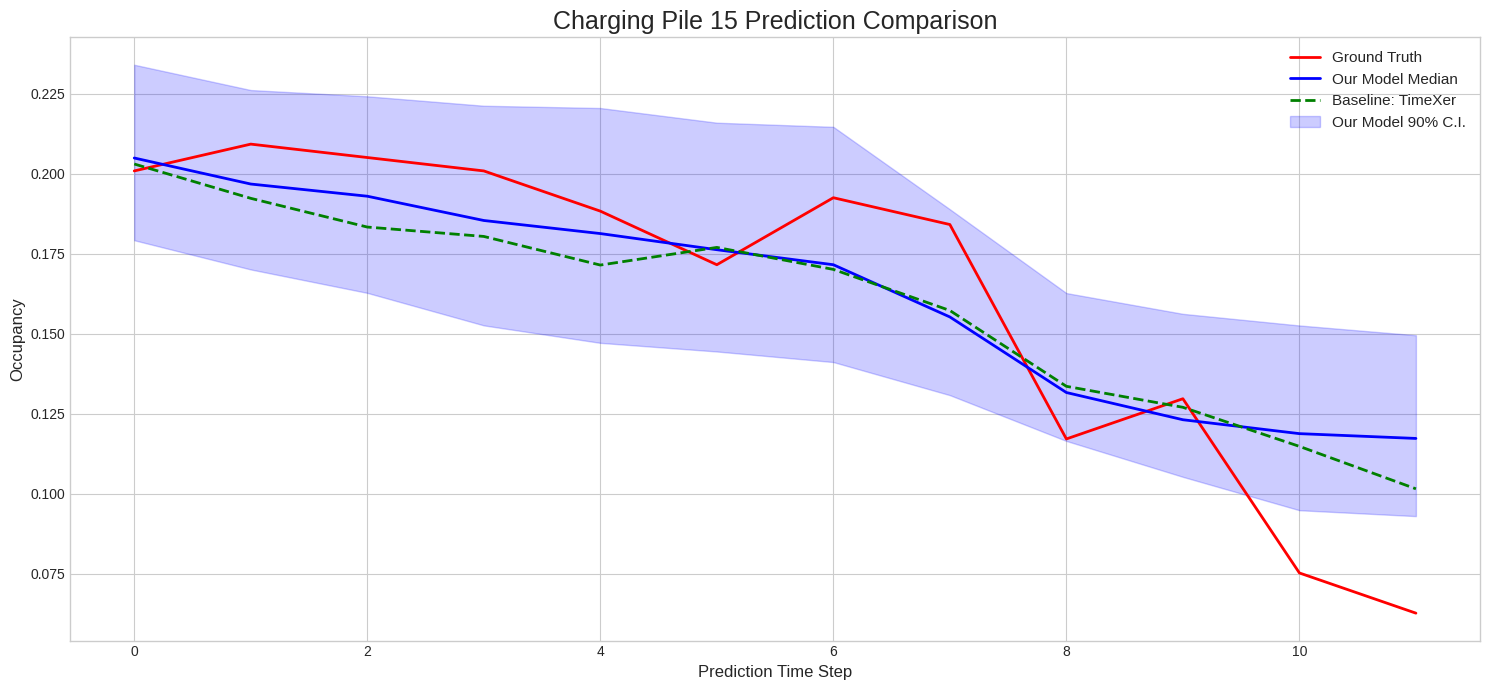

可视化图表已保存至: prediction_visualization.png


<Figure size 640x480 with 0 Axes>

In [110]:


# --- 2. 设置可视化参数 ---
sample_idx_to_plot = 50  # 选择第50个测试样本进行可视化
node_idx_to_plot = 15   # 选择第15个充电桩（节点）进行可视化

# --- 3. 准备绘图所需的数据 ---
# 提取特定样本和节点的数据
true_future = ground_truths[sample_idx_to_plot, :, node_idx_to_plot]
median_pred = model_predictions[sample_idx_to_plot, :, node_idx_to_plot]
all_samples = model_samples[sample_idx_to_plot, :, :, node_idx_to_plot]
baseline_pred = baseline_predictions[sample_idx_to_plot, :, node_idx_to_plot]

# --- 4. 调用绘图函数 ---
plot_timeseries_with_uncertainty(
    ground_truth=true_future,
    median_prediction=median_pred,
    prediction_samples=all_samples,
    baseline_prediction=baseline_pred,
    node_idx=node_idx_to_plot
)

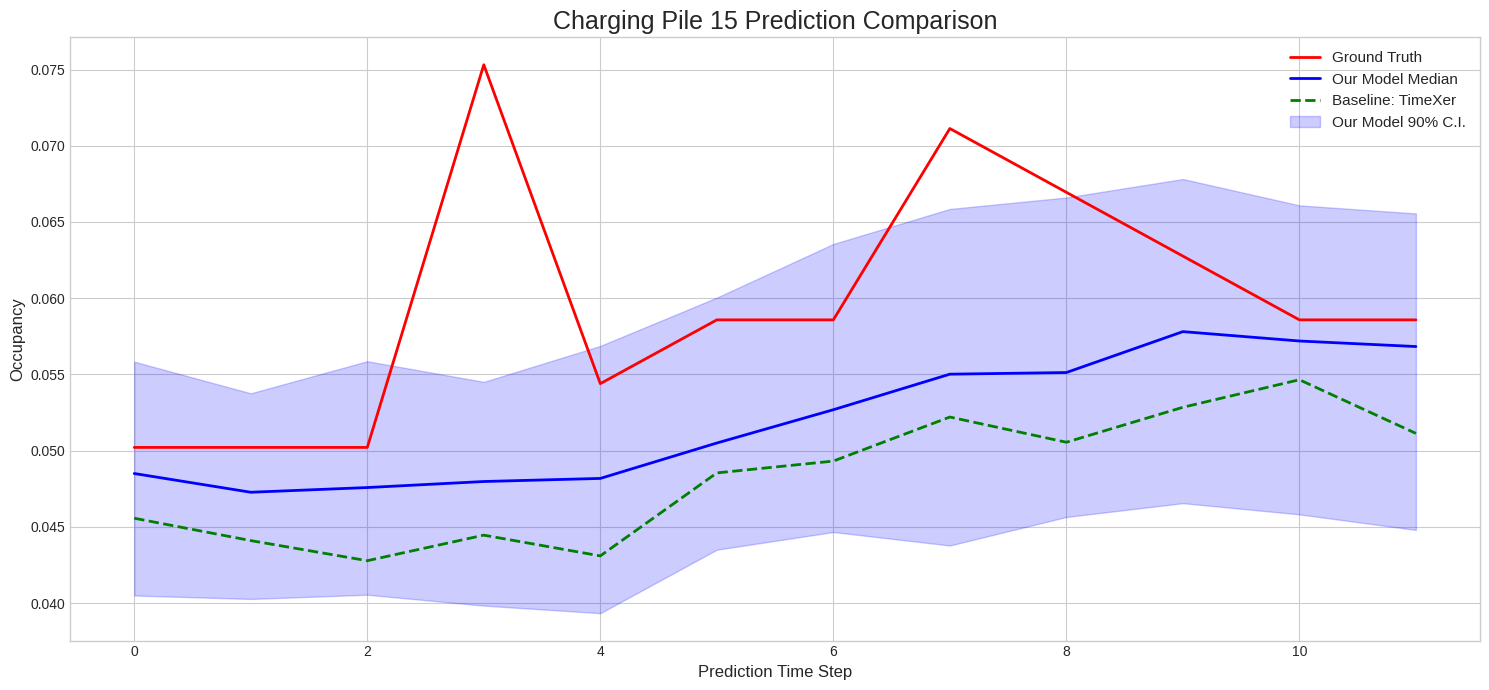

可视化图表已保存至: prediction_visualization.png


<Figure size 640x480 with 0 Axes>

In [82]:
# --- 2. 设置可视化参数 ---
sample_idx_to_plot = 20  # 选择第50个测试样本进行可视化
node_idx_to_plot = 15   # 选择第15个充电桩（节点）进行可视化

# --- 3. 准备绘图所需的数据 ---
# 提取特定样本和节点的数据
true_future = ground_truths[sample_idx_to_plot, :, node_idx_to_plot]
median_pred = model_predictions[sample_idx_to_plot, :, node_idx_to_plot]
all_samples = model_samples[sample_idx_to_plot, :, :, node_idx_to_plot]
baseline_pred = baseline_predictions[sample_idx_to_plot, :, node_idx_to_plot]

# --- 4. 调用绘图函数 ---
plot_timeseries_with_uncertainty(
    ground_truth=true_future,
    median_prediction=median_pred,
    prediction_samples=all_samples,
    baseline_prediction=baseline_pred,
    node_idx=node_idx_to_plot
)

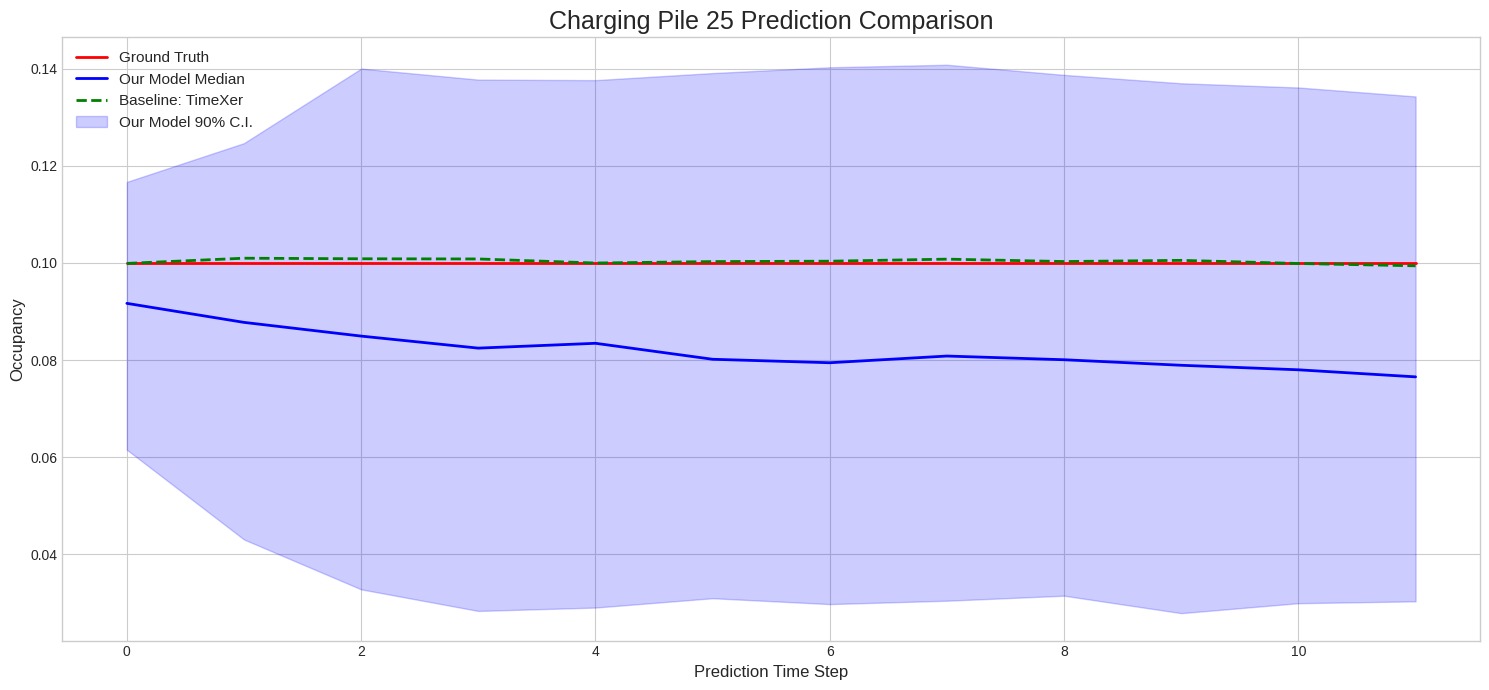

可视化图表已保存至: prediction_visualization.png


<Figure size 640x480 with 0 Axes>

In [83]:
# --- 2. 设置可视化参数 ---
sample_idx_to_plot = 12  # 选择第50个测试样本进行可视化
node_idx_to_plot = 25   # 选择第15个充电桩（节点）进行可视化

# --- 3. 准备绘图所需的数据 ---
# 提取特定样本和节点的数据
true_future = ground_truths[sample_idx_to_plot, :, node_idx_to_plot]
median_pred = model_predictions[sample_idx_to_plot, :, node_idx_to_plot]
all_samples = model_samples[sample_idx_to_plot, :, :, node_idx_to_plot]
baseline_pred = baseline_predictions[sample_idx_to_plot, :, node_idx_to_plot]

# --- 4. 调用绘图函数 ---
plot_timeseries_with_uncertainty(
    ground_truth=true_future,
    median_prediction=median_pred,
    prediction_samples=all_samples,
    baseline_prediction=baseline_pred,
    node_idx=node_idx_to_plot
)

In [85]:
address=pd.read_csv('urbanev/inf.csv')
address.sort_values(by="TAZID", ascending=True, inplace=True)
address

,TAZID,longitude,latitude,charge_count,area,perimeter
168,102,114.102962,22.540413,30,7.144193e+05,3501.2154
161,104,114.113986,22.553131,19,1.171734e+06,4683.8446
160,105,114.120846,22.551266,93,7.725567e+05,3472.0644
166,106,114.121880,22.544272,114,5.787174e+05,3486.9251
94,107,114.130389,22.544861,95,8.887169e+05,4445.4393
...,...,...,...,...,...,...
111,1166,114.127249,22.604594,161,2.372234e+06,6724.5788
98,1167,114.145276,22.599219,446,6.133971e+06,18053.4776
100,1168,114.048664,22.571472,43,1.441848e+06,8021.7389
101,1172,114.057007,22.572841,37,1.101210e+06,4761.0116


In [118]:
def calculate_spatial_error(ground_truths, predictions, metric='mae'):
    """
    计算每个节点的指定指标 (MAE, RMSE, MAPE, RAE)。

    假定输入 shape 为 (B, L, N)，其中 N 是最后一个维度 (节点)。
    函数将在除最后一个维度之外的所有维度上聚合。

    参数:
    ground_truths (np.ndarray): 真实值数组。
    predictions (np.ndarray): 预测值数组。
    metric (str): 要计算的指标。可选值为:
                    'mae' (默认), 'rmse', 'mape', 'rae'

    返回:
    np.ndarray: 一个 shape 为 (N,) 的数组，包含每个节点的指标值。
    """
    
    # 确保是 numpy 数组
    ground_truths = np.asarray(ground_truths)
    predictions = np.asarray(predictions)
    
    if ground_truths.shape != predictions.shape:
        raise ValueError("ground_truths 和 predictions 必须具有相同的 shape")
    
    # 我们假设最后一个维度是节点(N)。
    # 我们将在所有其他维度上聚合 (例如, B 和 L)
    agg_axes = tuple(range(ground_truths.ndim - 1))
    
    # 用于防止除以零的极小值
    epsilon = 1e-9

    # --- 计算指标 ---
    
    if metric.lower() == 'mae':
        # 平均绝对误差
        abs_errors = np.abs(predictions - ground_truths)
        metric_per_node = np.mean(abs_errors, axis=agg_axes)
        
    elif metric.lower() == 'rmse':
        # 均方根误差
        squared_errors = np.square(predictions - ground_truths)
        mse_per_node = np.mean(squared_errors, axis=agg_axes)
        metric_per_node = np.sqrt(mse_per_node)

    elif metric.lower() == 'mse':
        # 均方根误差
        squared_errors = np.square(predictions - ground_truths)
        metric_per_node = np.mean(squared_errors, axis=agg_axes)
        
    elif metric.lower() == 'mape':
        # 平均绝对百分比误差
        abs_errors = np.abs(predictions - ground_truths)
        abs_gt = np.abs(ground_truths)
        
        # 创建一个掩码，只选择 gt 不为零的地方
        non_zero_mask = (abs_gt > epsilon)
        
        # 初始化百分比误差数组
        percentage_errors = np.zeros_like(ground_truths)
        
        # 仅在非零处计算百分比误差
        percentage_errors[non_zero_mask] = abs_errors[non_zero_mask] / abs_gt[non_zero_mask]
        
        # 为了正确计算平均值，我们需要用总和除以非零条目的 *数量*
        sum_pe_per_node = np.sum(percentage_errors, axis=agg_axes)
        non_zero_count_per_node = np.sum(non_zero_mask, axis=agg_axes)
        
        # 避免除以零 (如果某个节点所有真值都为0)
        metric_per_node = sum_pe_per_node / (non_zero_count_per_node + epsilon)
        metric_per_node = metric_per_node * 100 # 转换为百分比
        
    elif metric.lower() == 'rae':
        # 相对绝对误差
        abs_errors = np.abs(predictions - ground_truths)
        numerator = np.sum(abs_errors, axis=agg_axes) # Shape (N,)
        
        # 计算分母：真实值与其“节点平均值”之间的绝对误差总和
        # 使用 keepdims=True 来保持维度 (1, 1, N) 以便广播
        gt_mean_per_node_broadcast = np.mean(ground_truths, axis=agg_axes, keepdims=True)
        
        denominator_errors = np.abs(ground_truths - gt_mean_per_node_broadcast)
        denominator = np.sum(denominator_errors, axis=agg_axes) # Shape (N,)
        
        metric_per_node = numerator / (denominator + epsilon)
        
    else:
        raise ValueError(f"不支持的指标: {metric}. 可选值为: 'mae', 'rmse', 'mape', 'rae'")

    return metric_per_node

def plot_error_maps(our_model_error, baseline_error, locations):
    """
    绘制并排的两个空间误差分布热力图，用于对比。
    """

    plt.style.use('seaborn-v0_8-whitegrid')
    # --- 修改：使用 constrained_layout=True 来自动处理布局 ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True, constrained_layout=True)
    
    min_error = min(our_model_error.min(), baseline_error.min())
    max_error = max(our_model_error.max(), baseline_error.max())

    # 绘制左图：我们的模型
    ax1 = axes[0]
    scatter1 = ax1.scatter(
        locations[:, 0],  # 经度
        locations[:, 1],  # 纬度
        c=our_model_error,
        cmap='plasma_r',
        s=50,
        vmin=min_error,
        vmax=max_error
    )
    ax1.set_title("Our Model's Spatial Error Distribution", fontsize=18)
    ax1.set_xlabel('Longitude', fontsize=12)
    ax1.set_ylabel('Latitude', fontsize=12)
    ax1.grid(True)
    ax1.tick_params(axis='x', rotation=45)

    # 绘制右图：基线模型
    ax2 = axes[1]
    scatter2 = ax2.scatter(
        locations[:, 0],
        locations[:, 1],
        c=baseline_error,
        cmap='plasma_r',
        s=50,
        vmin=min_error,
        vmax=max_error
    )
    ax2.set_title("Baseline Model's Spatial Error Distribution", fontsize=18)
    ax2.set_xlabel('Longitude', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True)
    
    fig.colorbar(scatter2, ax=axes, orientation='vertical', label='MAE')
    
    fig.suptitle('Spatial Error Distribution Comparison', fontsize=22)
    plt.show()

正在从 address.csv 加载地理坐标...
正在从 address.csv 加载地理坐标...
正在检查经纬度为零的站点...
检查完毕，未发现经纬度为零的站点。
正在计算空间误差...

正在生成空间误差对比图...


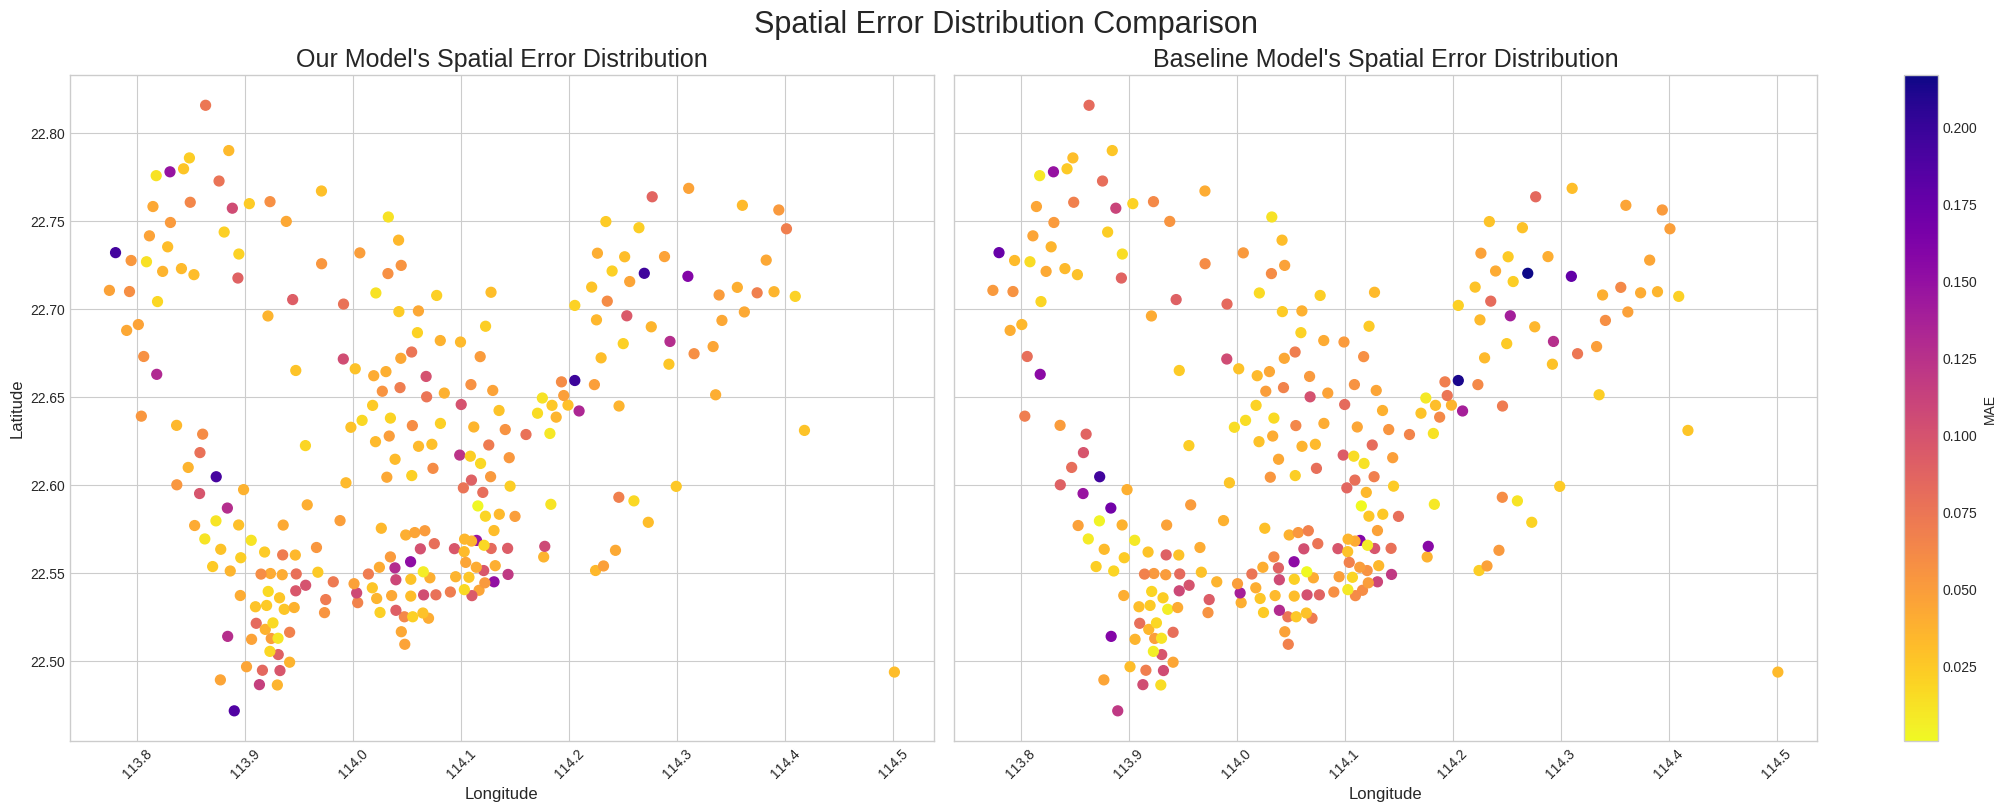

In [114]:
try:
    
    # --- 修改：从 address.csv 加载地理位置数据 ---
    print("正在从 address.csv 加载地理坐标...")
    print("正在从 address.csv 加载地理坐标...")
    address_df = pd.read_csv("urbanev/inf.csv")

    # --- 新增：查找并打印经纬度为零的站点 ---
    print("正在检查经纬度为零的站点...")
    zero_coord_stations = address_df[(address_df['longitude'] == 0) | (address_df['latitude'] == 0)]
    if not zero_coord_stations.empty:
        print("警告: 发现以下站点的经纬度为零或无效:")
        print(zero_coord_stations)
    else:
        print("检查完毕，未发现经纬度为零的站点。")
    
    # 从DataFrame中提取经纬度列，并转换为numpy数组
    node_locations = address_df[['longitude', 'latitude']].values

except FileNotFoundError as e:
    print(f"错误: 找不到数据文件 {e.filename}。请确保所有需要的.npy和.csv文件都存在。")
    # exit()

# --- 计算每个模型的空间误差 ---
print("正在计算空间误差...")
our_error = calculate_spatial_error(ground_truths, model_predictions,'rmse')
baseline_error = calculate_spatial_error(ground_truths, baseline_predictions,'rmse')

# --- 调用绘图函数 ---
print("\n正在生成空间误差对比图...")
plot_error_maps(
    our_model_error=our_error,
    baseline_error=baseline_error,
    locations=node_locations
)

In [90]:
import geopandas as gpd
# 读取shp文件
shp = gpd.read_file("urbanev/SZ_districts/SZ_districts.shp")
shp_ids = set(shp["TAZID"].unique())

# 读取csv文件
csv = pd.read_csv("urbanev/inf.csv")
csv_ids = set(csv["TAZID"].unique())

# 检查是否都包含
missing_ids = csv_ids - shp_ids

if len(missing_ids) == 0:
    print("✅ inf.csv 中的 TAZID 全部包含在 shp 文件中")
else:
    print("⚠ 有缺失的 TAZID：", missing_ids)

✅ inf.csv 中的 TAZID 全部包含在 shp 文件中


In [92]:

# 在 shp 中新增一列，存在则标记为 1，否则为 0
shp["in_csv"] = shp["TAZID"].apply(lambda x: 1 if x in csv_ids else 0)

In [93]:
shp

,OBJECTID,TAZID,AREA,X,Y,ZONE,LENG_ROAD,SHAPE_Leng,SHAPE_Area,geometry,in_csv
0,1,1054.0,11.49,114.333530,22.783052,781.0,10.135,25856.846986,13581804.0,"POLYGON ((12727715 2609219, 12727838 2609098, ...",0
1,2,1052.0,17.07,114.282465,22.789111,775.0,6.368,30117.841314,20191527.5,"POLYGON ((12721609 2609078, 12721630 2608932, ...",0
2,3,850.0,2.85,114.322722,22.791482,780.0,4.822,10307.116136,3375499.0,"POLYGON ((12726477 2609132, 12726623 2609056, ...",0
3,4,1066.0,1.57,113.910301,22.521287,307.0,7.130,5552.707185,1857995.0,"POLYGON ((12680558 2573496, 12680096 2573463, ...",1
4,5,1068.0,1.41,113.918680,22.517837,306.0,7.084,5930.667262,1654644.0,"POLYGON ((12681747 2573552, 12681409 2572621, ...",1
...,...,...,...,...,...,...,...,...,...,...,...
486,487,941.0,11.22,114.558370,22.617653,830.0,0.000,32266.003804,13227019.0,"POLYGON ((12756192 2590194, 12756219 2590186, ...",0
487,488,902.0,4.50,114.355630,22.712196,804.0,0.000,10818.341390,5320351.0,"POLYGON ((12729111 2596043, 12728621 2595461, ...",1
488,489,974.0,3.64,114.144484,22.615399,710.0,9.146,8761.589269,4298492.5,"POLYGON ((12707932 2585276, 12707971 2584805, ...",1
489,490,1154.0,1.23,114.224404,22.551290,401.0,9.541,5918.395932,1454578.0,"POLYGON ((12715562 2576929, 12715385 2576903, ...",1


In [94]:
def calculate_spatial_error(ground_truths, predictions):
    """
    计算每个节点的平均绝对误差(MAE)。
    """
    abs_errors = np.abs(predictions - ground_truths)
    mae_per_node = np.mean(abs_errors, axis=(0, 1))
    return mae_per_node

def plot_error_maps_with_shp(shp, our_model_error, baseline_error):
    """
    绘制并排的两个空间误差分布热力图，用于对比。
    """

    shp_filtered = shp[shp["in_csv"] == 1].sort_values("TAZID").reset_index(drop=True)

    # 提取几何中心点坐标（用于 scatter 对应模型预测结果）
    shp_filtered["centroid"] = shp_filtered.geometry.centroid
    locations = np.array([[pt.x, pt.y] for pt in shp_filtered["centroid"]])

    # 确保误差结果与 shp 顺序一致
    # 假设 model_predictions 和 baseline_predictions 的顺序也是按 TAZID 升序
    # 如果不是，需要单独对齐索引
    our_error = our_model_error
    baseline_error = baseline_error

    # --- 画图 ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True, sharex=True, sharey=True)
    
    min_error = min(our_error.min(), baseline_error.min())
    max_error = max(our_error.max(), baseline_error.max())

    # 左图：我们的模型
    ax1 = axes[0]
    shp.plot(ax=ax1, color="lightgrey", edgecolor="white")  # 底图
    scatter1 = ax1.scatter(
        locations[:, 0], locations[:, 1],
        c=our_error,
        cmap="plasma_r",
        s=50,
        vmin=min_error, vmax=max_error
    )
    ax1.set_title("Our Model's Spatial Error Distribution", fontsize=18)
    ax1.set_xlabel("Longitude", fontsize=12)
    ax1.set_ylabel("Latitude", fontsize=12)
    ax1.grid(True)

    # 右图：基线模型
    ax2 = axes[1]
    shp.plot(ax=ax2, color="lightgrey", edgecolor="white")
    scatter2 = ax2.scatter(
        locations[:, 0], locations[:, 1],
        c=baseline_error,
        cmap="plasma_r",
        s=50,
        vmin=min_error, vmax=max_error
    )
    ax2.set_title("Baseline Model's Spatial Error Distribution", fontsize=18)
    ax2.set_xlabel("Longitude", fontsize=12)
    ax2.grid(True)

    # 公共 colorbar
    fig.colorbar(scatter2, ax=axes, orientation="vertical", label="MAE")
    fig.suptitle("Spatial Error Distribution Comparison", fontsize=22)
    plt.show()

正在从 address.csv 加载地理坐标...
正在检查经纬度为零的站点...
检查完毕，未发现经纬度为零的站点。
正在计算空间误差...

正在生成空间误差对比图...


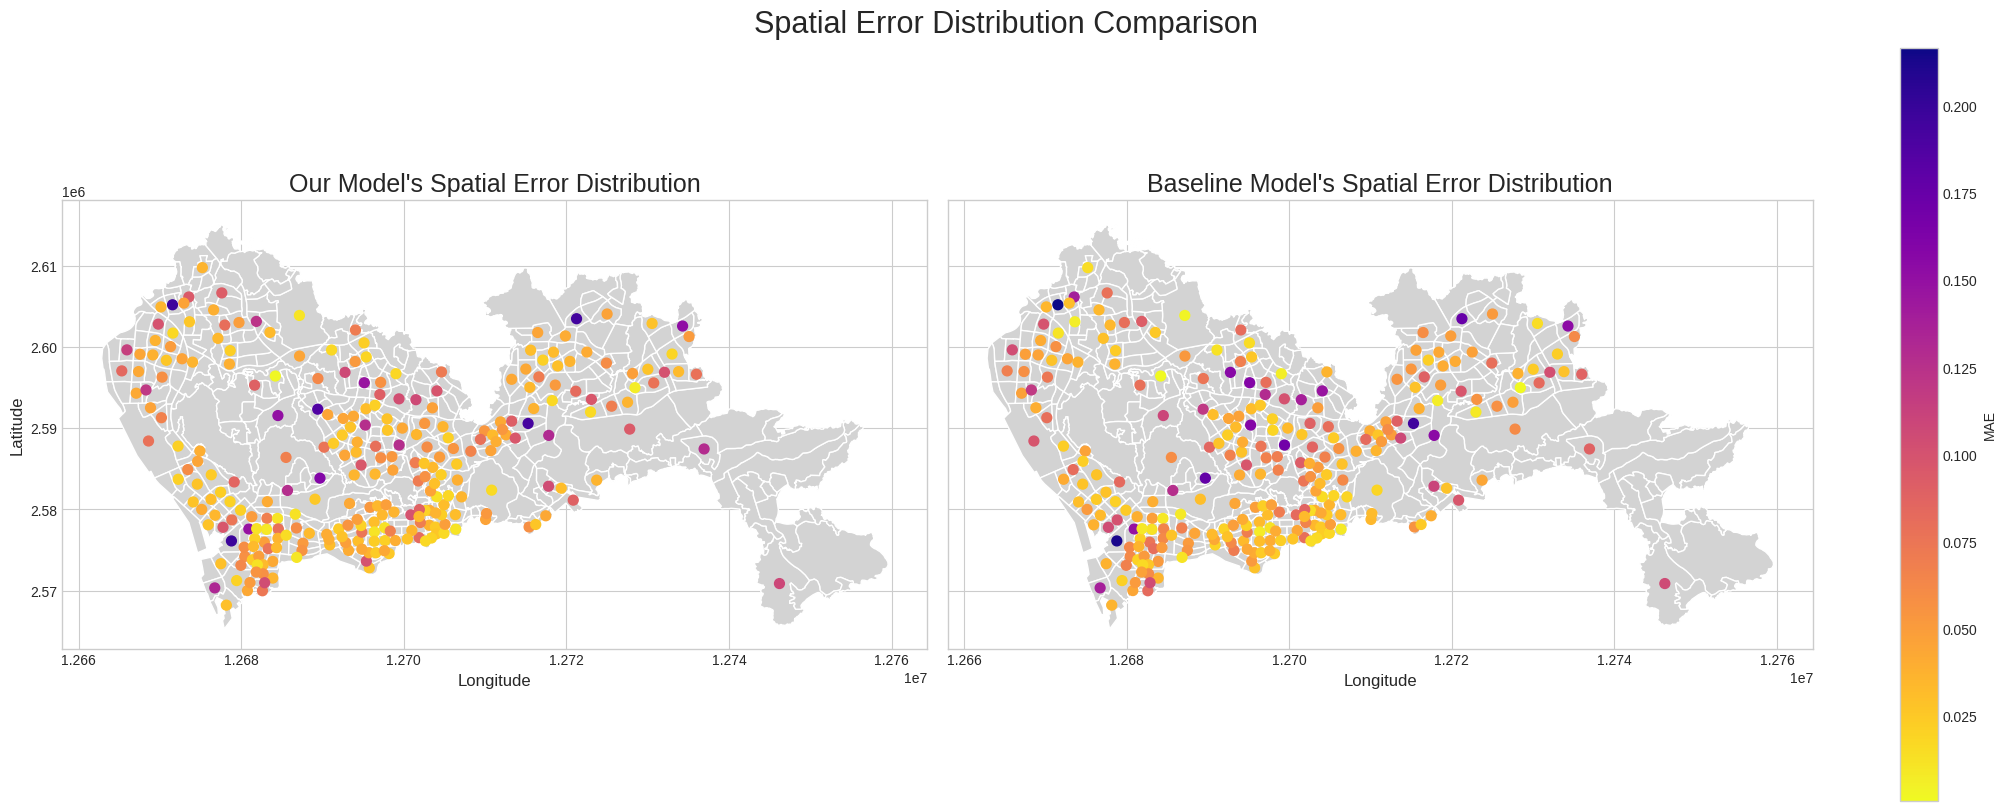

In [115]:
try:
    
    # --- 修改：从 address.csv 加载地理位置数据 ---
    print("正在从 address.csv 加载地理坐标...")
    address_df = pd.read_csv("urbanev/inf.csv")

    # --- 新增：查找并打印经纬度为零的站点 ---
    print("正在检查经纬度为零的站点...")
    zero_coord_stations = address_df[(address_df['longitude'] == 0) | (address_df['latitude'] == 0)]
    if not zero_coord_stations.empty:
        print("警告: 发现以下站点的经纬度为零或无效:")
        print(zero_coord_stations)
    else:
        print("检查完毕，未发现经纬度为零的站点。")
    
    # 从DataFrame中提取经纬度列，并转换为numpy数组
    node_locations = address_df[['longitude', 'latitude']].values

except FileNotFoundError as e:
    print(f"错误: 找不到数据文件 {e.filename}。请确保所有需要的.npy和.csv文件都存在。")
    # exit()

# --- 计算每个模型的空间误差 ---
print("正在计算空间误差...")
our_error = calculate_spatial_error(ground_truths, model_predictions,'rmse')
baseline_error = calculate_spatial_error(ground_truths, baseline_predictions,'rmse')

# --- 调用绘图函数 ---
print("\n正在生成空间误差对比图...")
plot_error_maps_with_shp(
    shp=shp,
    our_model_error=our_error,
    baseline_error=baseline_error
)

正在从 address.csv 加载地理坐标...
正在检查经纬度为零的站点...
检查完毕，未发现经纬度为零的站点。
正在计算空间误差...

正在生成空间误差对比图...


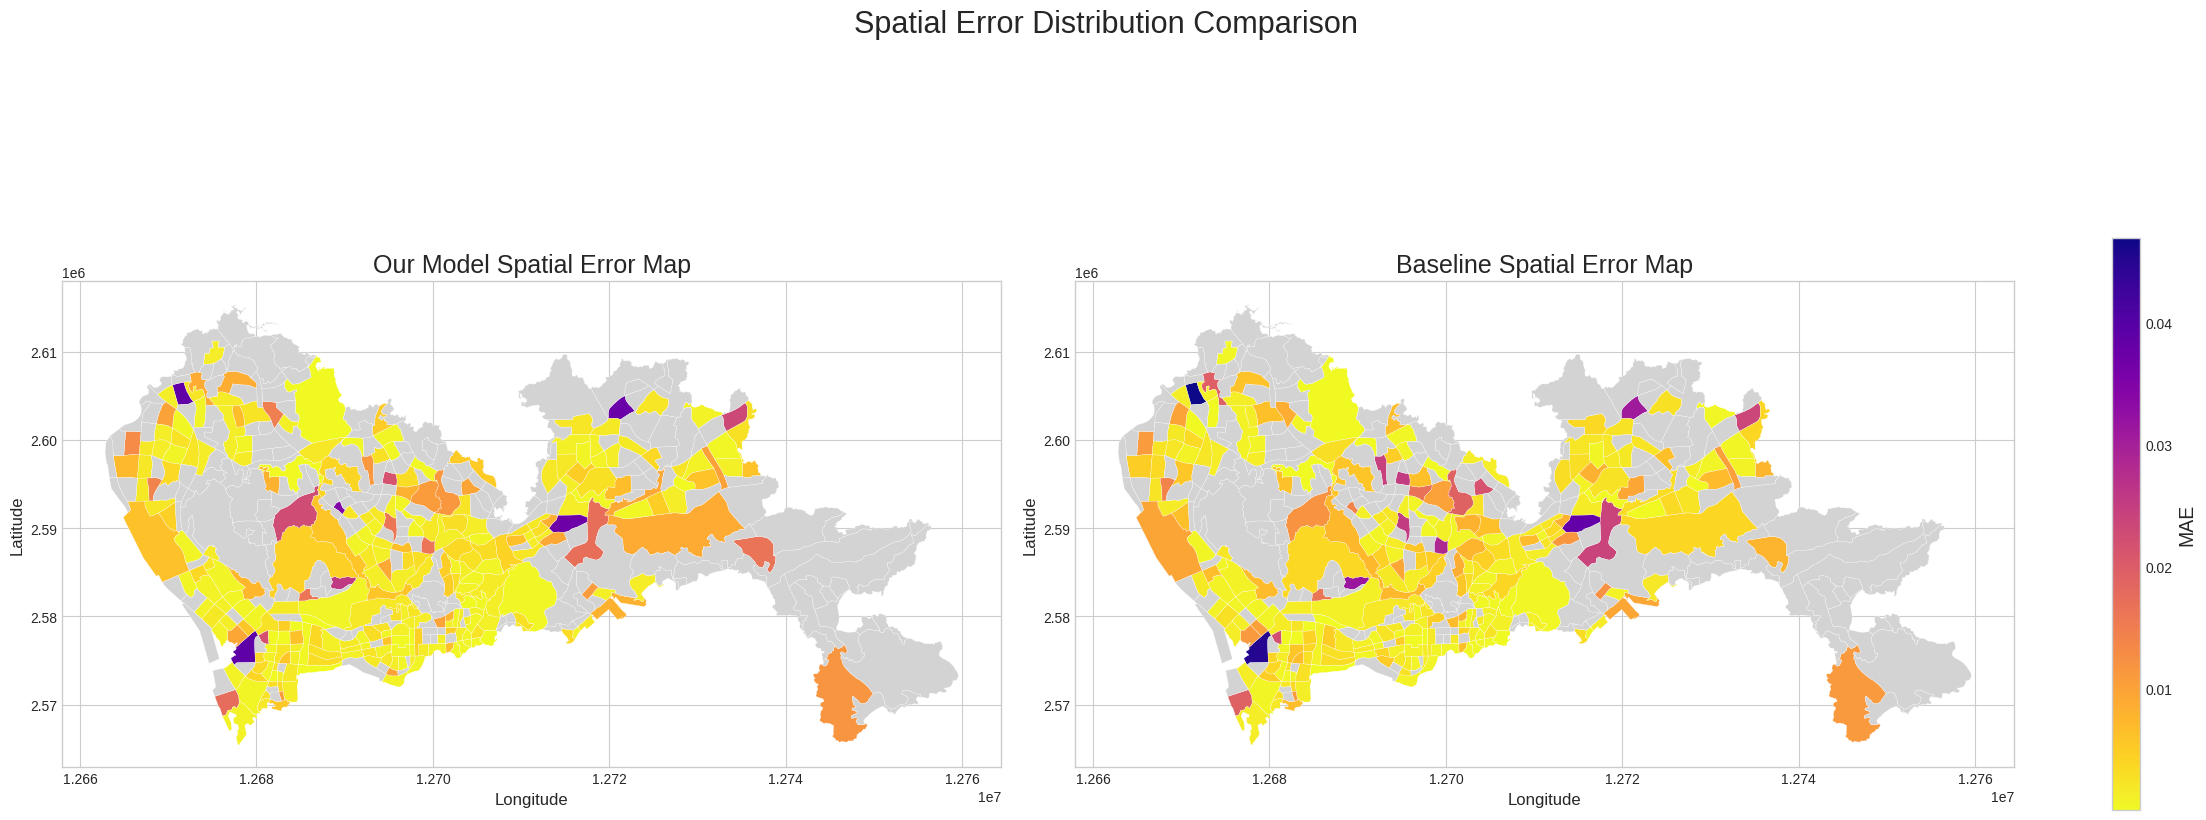

In [119]:
def plot_error_maps_with_shp_filled(shp, our_model_error, baseline_error):
    """
    依据误差对区域上色（Choropleth Map），无数据区域填充灰色。
    保留坐标轴与边框，适合论文展示。
    """

    # 复制 shp 防止修改原数据
    shp_plot = shp.copy()

    # 按 TAZID 排序，只给 in_csv==1 的区域填入误差值
    shp_plot = shp_plot.sort_values("TAZID").reset_index(drop=True)

    # 所有区域先标记为 NaN（即无数据区域）
    shp_plot["our_error"] = np.nan
    shp_plot["baseline_error"] = np.nan

    # 给有数据的区域填误差
    valid_mask = shp_plot["in_csv"] == 1
    shp_plot.loc[valid_mask, "our_error"] = our_model_error
    shp_plot.loc[valid_mask, "baseline_error"] = baseline_error

    # 色阶范围一致，便于对比
    vmin = min(np.nanmin(shp_plot["our_error"]), np.nanmin(shp_plot["baseline_error"]))
    vmax = max(np.nanmax(shp_plot["our_error"]), np.nanmax(shp_plot["baseline_error"]))

    fig, axes = plt.subplots(1, 2, figsize=(22, 10), constrained_layout=True)

    # --- 左图：Our Model ---
    shp_plot.plot(
        column="our_error",
        cmap="plasma_r",
        linewidth=0.2,
        edgecolor="white",            # ✅ 边框
        vmin=vmin, vmax=vmax,
        missing_kwds={                # ✅ 无数据区域填充灰色
            "color": "lightgrey",
            "edgecolor": "white",
            # "hatch": "//",
            "label": "No Data"
        },
        ax=axes[0]
    )
    axes[0].set_title("Our Model Spatial Error Map", fontsize=18)
    axes[0].set_xlabel("Longitude", fontsize=12)
    axes[0].set_ylabel("Latitude", fontsize=12)
    axes[0].grid(True)                # ✅ 保留坐标格网

    # --- 右图：Baseline Model ---
    shp_plot.plot(
        column="baseline_error",
        cmap="plasma_r",
        linewidth=0.2,
        edgecolor="white",            # ✅ 边框
        vmin=vmin, vmax=vmax,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "white",
            "label": "No Data"
        },
        ax=axes[1]
    )
    axes[1].set_title("Baseline Spatial Error Map", fontsize=18)
    axes[1].set_xlabel("Longitude", fontsize=12)
    axes[1].set_ylabel("Latitude", fontsize=12)
    axes[1].grid(True)

    # ✅ 公共 Colorbar
    sm = plt.cm.ScalarMappable(cmap="plasma_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=axes, shrink=0.6, fraction=0.05)
    cbar.set_label("MAE", fontsize=14)

    fig.suptitle("Spatial Error Distribution Comparison", fontsize=22)
    plt.show()



try:
    
    # --- 修改：从 address.csv 加载地理位置数据 ---
    print("正在从 address.csv 加载地理坐标...")
    address_df = pd.read_csv("urbanev/inf.csv")

    # --- 新增：查找并打印经纬度为零的站点 ---
    print("正在检查经纬度为零的站点...")
    zero_coord_stations = address_df[(address_df['longitude'] == 0) | (address_df['latitude'] == 0)]
    if not zero_coord_stations.empty:
        print("警告: 发现以下站点的经纬度为零或无效:")
        print(zero_coord_stations)
    else:
        print("检查完毕，未发现经纬度为零的站点。")
    
    # 从DataFrame中提取经纬度列，并转换为numpy数组
    node_locations = address_df[['longitude', 'latitude']].values

except FileNotFoundError as e:
    print(f"错误: 找不到数据文件 {e.filename}。请确保所有需要的.npy和.csv文件都存在。")
    # exit()

# --- 计算每个模型的空间误差 ---
print("正在计算空间误差...")
our_error = calculate_spatial_error(ground_truths, model_predictions,'mse')
baseline_error = calculate_spatial_error(ground_truths, baseline_predictions,'mse')

# --- 调用绘图函数 ---
print("\n正在生成空间误差对比图...")
plot_error_maps_with_shp_filled(
    shp=shp,
    our_model_error=our_error,
    baseline_error=baseline_error
)


In [77]:
shp_df = shp[["TAZID", "X", "Y"]].copy()
csv_df = csv[["TAZID", "longitude", "latitude"]].copy()

# 按 TAZID 对齐
merged = pd.merge(
    shp_df, csv_df,
    on="TAZID",
    suffixes=("_shp", "_csv"),
    how="inner"
)

# 检查是否一致
merged["lon_equal"] = merged["X"] == merged["longitude"]
merged["lat_equal"] = merged["Y"] == merged["latitude"]

# 找出不一致的记录
diff = merged[(~merged["lon_equal"]) | (~merged["lat_equal"])]

if diff.empty:
    print("✅ inf.csv 和 shp 中相同 TAZID 的经纬度完全一致")
else:
    print("⚠ 发现经纬度不一致的记录：")
    print(diff[["TAZID", "X", "Y", "longitude", "latitude"]])

✅ inf.csv 和 shp 中相同 TAZID 的经纬度完全一致


In [79]:
true_baseline = np.load("results/trues.npy")

In [81]:
true_baseline.shape

(412, 12, 275)

In [82]:
ground_truths.shape

(412, 12, 275)